In [1]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms 
from PIL import Image 
import os
from tqdm import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

C:\Users\mihai\anaconda3\envs\gpu_env\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\Images_datasets\images_dataset_cnn_multi'

In [3]:
transform = transforms.Compose([
    transforms.Resize((385, 422)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=videos_path, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 110
    Root location: C:\Users\mihai\Desktop\forehand-analysis\images_datasets\images_dataset_cnn_multi
    StandardTransform
Transform: Compose(
               Resize(size=(385, 422), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [4]:
# img, label = dataset[124]
# img_height = img.shape[1]
# img_width = img.shape[2]
# print(img.shape)
# plt.imshow(img.permute(1, 2, 0))

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Conv2d(3, 16, 3) 
        self.layer2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.activation = nn.ReLU()
        self.layer3 = nn.Linear(312832, 128)
        self.fc = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        #print(x.shape)
        x = self.activation(self.layer1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.activation(self.layer2(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.activation(self.layer3(x))
        #print(x.shape)
        x = self.fc(x)
        return x.squeeze(1)

In [6]:
model = ConvNet()

In [7]:
#model(img.reshape(1,3,img_height,img_width)) # dodajemo batch_size=1

In [8]:
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model.to(device)

ConvNet(
  (layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (layer3): Linear(in_features=312832, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
#other_test_indices = list(range(43, 53)) + list(range(101, 108)) + list(range(156, 163))

In [10]:
other_test_indices = list(range(48, 55)) + list(range(103, 110))
dataset_indices = [x for x in range(len(dataset)) if x not in other_test_indices]
dataset_labels = [dataset.targets[i] for i in dataset_indices]

#dataset_indices

In [11]:
random_state=42

In [12]:
whole_train_idx, test_idx = train_test_split(dataset_indices, test_size=30, stratify=dataset_labels, random_state=random_state)
test_dataset = Subset(dataset, test_idx)
len(test_dataset)

30

In [13]:
whole_train_dataset = Subset(dataset, whole_train_idx)
wtd_labels = [dataset.targets[i] for i in whole_train_idx]
#print(wtd_labels)
train_idx, val_idx = train_test_split(whole_train_idx, test_size=15, stratify=wtd_labels, random_state=random_state)
val_dataset = Subset(dataset, val_idx)
len(val_dataset)

15

In [14]:
train_dataset = Subset(dataset, train_idx)
len(train_dataset)

51

In [15]:
other_test_dataset = Subset(dataset, other_test_indices)
len(other_test_dataset)

14

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)
other_test_loader = DataLoader(other_test_dataset, batch_size=4)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    
    total_loss = 0
    num_same = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device, dtype=torch.float32) 
        
        #forward pass
        outputs = model(X)
        loss = loss_fn(outputs, y)
        total_loss += loss.item()
        
        if len(outputs.shape) == 1: # accuracy - dve klase
            preds = outputs > 0
            num_same += sum(preds == y).item()
                
        else: # accuracy - vise klasa
            _, indices = torch.max(outputs, 1)
            num_same += sum(indices == y).item()
        
        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(dataloader.dataset)
    acc = num_same / len(dataloader.dataset)
    return avg_loss, acc

In [18]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        
        for X, y in dataloader:
            X, y = X.to(device), y.to(device, dtype=torch.float32) 
            
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy - dve klase
                preds = outputs > 0
                print(outputs)
                print(preds, " : ", y)
                num_same += sum(preds == y).item()
                
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1)
                print(outputs)
                print(indices, " : ", y)
                num_same += sum(indices == y).item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        acc = num_same / len(dataloader.dataset)
        print(f'Average loss: {avg_loss}')
        print(f'Accuracy: {acc}')
        print()
        
        return avg_loss, acc

In [19]:
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = float('-inf')
last_val_acc = float('-inf')
best_model_weights = model.state_dict()
best_epoch = -1

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = test_loop(val_loader, model, loss_fn, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc and val_acc == last_val_acc:
        #print(val_acc)
        best_val_acc = val_acc
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, './Models/best_model_cnn_multi.pth')
        best_epoch = epoch

    last_val_acc = val_acc
    
print(val_acc, ' : ', best_val_acc)
if best_val_acc < val_acc:
    best_epoch = epoch
    torch.save(model.state_dict(), './Models/best_model_cnn_multi.pth')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

tensor([1.4114, 1.8187, 1.3339, 1.3677])
tensor([True, True, True, True])  :  tensor([0., 1., 0., 0.])
tensor([1.4684, 1.4365, 1.6408, 1.4574])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([1.6651, 1.4548, 1.4490, 1.5334])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])


  5%|████▏                                                                              | 1/20 [00:05<01:53,  5.99s/it]

tensor([1.4092, 1.6759, 1.5548])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.2606862862904867
Accuracy: 0.4666666666666667

tensor([-0.5234,  4.3853, -0.2531, -1.4295])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([2.6722, 1.6392, 0.2157, 0.3731])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])


 10%|████████▎                                                                          | 2/20 [00:11<01:42,  5.70s/it]

tensor([1.0923, 2.0244, 0.4612, 2.7730])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([ 0.0735,  1.4977, -0.5667])
tensor([ True,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.148963862657547
Accuracy: 0.7333333333333333

tensor([-5.1756,  3.6625, -5.1072, -5.5399])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.3453, -3.4362, -1.1872, -3.0741])
tensor([False, False, False, False])  :  tensor([0., 1., 1., 0.])
tensor([ 0.4025, -4.0559, -3.6338,  0.0927])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 15%|████████████▍                                                                      | 3/20 [00:17<01:36,  5.69s/it]

tensor([-4.6979,  0.8697, -3.0647])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1816242997845014
Accuracy: 0.8

tensor([-9.0161,  9.5290, -8.4361, -8.5068])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-1.5420, -2.6376,  5.9926, -3.4187])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 7.0796, -5.9288, -4.5480,  3.7104])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 20%|████████████████▌                                                                  | 4/20 [00:22<01:31,  5.71s/it]

tensor([-7.3425,  6.8610, -4.7961])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1486023442489871
Accuracy: 0.8666666666666667

tensor([-9.6676, 11.0283, -9.1377, -8.5187])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-0.8556, -2.1068,  9.2076, -2.9196])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.8209, -5.8091, -4.4552,  4.3966])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([-8.1464,  9.6705, -4.6708])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.14129501873297462
Accuracy: 0.8666666666666667



 25%|████████████████████▊                                                              | 5/20 [00:28<01:26,  5.75s/it]

tensor([-12.2465,  10.4537, -11.7366, -10.9214])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-3.0865, -4.3205,  7.8839, -5.0704])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 8.6619, -8.1131, -6.6210,  3.0931])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 30%|████████████████████████▉                                                          | 6/20 [00:34<01:19,  5.69s/it]

tensor([-10.7026,   8.2621,  -7.0506])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.2090969071690779
Accuracy: 0.8666666666666667

tensor([-12.9665,  10.4376, -12.4484, -11.5754])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-3.6422, -4.9194,  7.5119, -5.7310])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 8.3127, -8.6948, -7.1969,  2.7208])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 35%|█████████████████████████████                                                      | 7/20 [00:40<01:16,  5.91s/it]

tensor([-11.3576,   7.8934,  -7.8546])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.2286178571526155
Accuracy: 0.8666666666666667

tensor([-12.9188,  10.8226, -12.3918, -11.4810])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-3.4461, -4.7951,  7.7439, -5.6175])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 8.5444, -8.5870, -7.0677,  2.9618])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 40%|█████████████████████████████████▏                                                 | 8/20 [00:46<01:10,  5.88s/it]

tensor([-11.2731,   8.1260,  -7.7578])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.22464042507914808
Accuracy: 0.8666666666666667

tensor([-12.5157,  11.4844, -12.0097, -11.1743])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.9520, -4.2867,  8.2592, -5.2086])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.0765, -8.2634, -6.5709,  3.5046])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 45%|█████████████████████████████████████▎                                             | 9/20 [00:52<01:05,  5.91s/it]

tensor([-10.8238,   8.6702,  -7.3528])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.21088115467755414
Accuracy: 0.8666666666666667

tensor([-12.1778,  11.9794, -11.6663, -10.8143])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5598, -3.9031,  8.6727, -4.8492])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.4753, -7.8878, -6.1804,  3.9234])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 50%|█████████████████████████████████████████                                         | 10/20 [00:58<00:58,  5.85s/it]

tensor([-10.4533,   9.0656,  -7.0126])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1986144514417295
Accuracy: 0.8666666666666667

tensor([-12.1742,  12.0694, -11.6615, -10.8117])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5272, -3.8855,  8.6816, -4.8483])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.4877, -7.8735, -6.1523,  3.9584])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 55%|█████████████████████████████████████████████                                     | 11/20 [01:03<00:50,  5.64s/it]

tensor([-10.4334,   9.0731,  -7.0149])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1981184728470301
Accuracy: 0.8666666666666667

tensor([-12.1452,  12.1661, -11.6334, -10.7825])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.4793, -3.8472,  8.7304, -4.8150])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.5356, -7.8423, -6.1041,  4.0065])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:09<00:45,  5.69s/it]

tensor([-10.4037,   9.1176,  -6.9880])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.1970254024517999
Accuracy: 0.8666666666666667

tensor([-12.2515,  12.1401, -11.7474, -10.9110])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5681, -3.9468,  8.6307, -4.9241])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.4413, -7.9623, -6.1980,  3.9145])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:14<00:39,  5.61s/it]

tensor([-10.5170,   9.0200,  -7.1031])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.20055245361557658
Accuracy: 0.8666666666666667

tensor([-12.3330,  12.1264, -11.8422, -11.0115])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.6363, -4.0334,  8.5571, -5.0083])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.3735, -8.0511, -6.2698,  3.8326])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:19<00:33,  5.51s/it]

tensor([-10.6045,   8.9476,  -7.1899])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.20338394885008407
Accuracy: 0.8666666666666667

tensor([-12.3552,  12.1747, -11.8731, -11.0442])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.6422, -4.0562,  8.5547, -5.0220])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.3720, -8.0657, -6.2788,  3.8148])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:24<00:26,  5.38s/it]

tensor([-10.6273,   8.9417,  -7.2029])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.20399779962420628
Accuracy: 0.8666666666666667

tensor([-12.3126,  12.2845, -11.8307, -11.0020])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5792, -4.0034,  8.6268, -4.9668])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.4434, -8.0069, -6.2208,  3.8765])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:30<00:21,  5.37s/it]

tensor([-10.5746,   9.0098,  -7.1517])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.20221342277121343
Accuracy: 0.8666666666666667

tensor([-12.2301,  12.4262, -11.7459, -10.9157])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.4693, -3.9037,  8.7364, -4.8773])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.5507, -7.9105, -6.1251,  3.9880])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:35<00:16,  5.37s/it]

tensor([-10.4779,   9.1162,  -7.0614])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.19909160098607875
Accuracy: 0.8666666666666667

tensor([-12.2971,  12.4246, -11.8149, -10.9895])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5179, -3.9651,  8.6831, -4.9445])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.5021, -7.9722, -6.1886,  3.9319])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:41<00:11,  5.51s/it]

tensor([-10.5404,   9.0649,  -7.1220])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.2010679520781802
Accuracy: 0.8666666666666667

tensor([-12.3339,  12.4529, -11.8532, -11.0330])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5339, -3.9950,  8.6745, -4.9771])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.4918, -8.0064, -6.2208,  3.9114])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:46<00:05,  5.50s/it]

tensor([-10.5739,   9.0524,  -7.1425])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.20210884642813956
Accuracy: 0.8666666666666667

tensor([-12.3182,  12.5283, -11.8374, -11.0176])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-2.5055, -3.9696,  8.7177, -4.9559])
tensor([False, False,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ 9.5296, -7.9832, -6.1924,  3.9439])
tensor([ True, False, False,  True])  :  tensor([1., 1., 0., 1.])


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.62s/it]

tensor([-10.5489,   9.0876,  -7.1190])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.2013355682115313
Accuracy: 0.8666666666666667

0.8666666666666667  :  0.8666666666666667


In [20]:
print(best_epoch)

4


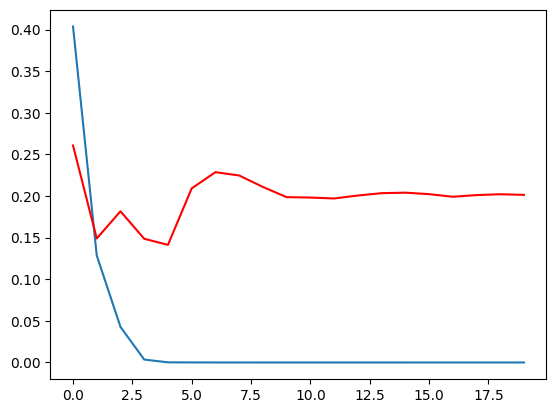

In [21]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), val_losses, color='red')

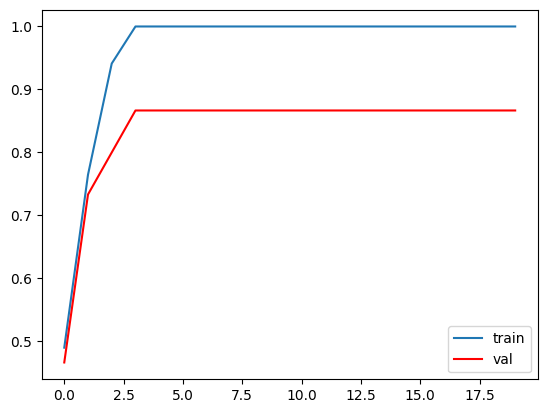

In [22]:
plt.plot(range(num_epochs), train_accs, label='train')
plt.plot(range(num_epochs), val_accs, color='red', label='val')
plt.legend()

In [23]:
model.load_state_dict(torch.load('./Models/best_model_cnn_multi.pth'))

<All keys matched successfully>

In [24]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn, device)

tensor([-8.7962, -7.8440, 11.2163, 13.4148])
tensor([False, False,  True,  True])  :  tensor([0., 0., 1., 1.])
tensor([ 4.8751, 10.4920, -8.6729, -6.1111])
tensor([ True,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([-1.6497,  5.5684, -6.1991, 10.9773])
tensor([False,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([ 9.4208, -3.8261, 11.4973,  0.9116])
tensor([ True, False,  True,  True])  :  tensor([1., 0., 1., 1.])
tensor([ -1.8373, -12.4057,  -8.8778,   5.2602])
tensor([False, False, False,  True])  :  tensor([0., 0., 0., 1.])
tensor([-11.8247, -10.5078,  -1.0127, -13.6164])
tensor([False, False, False, False])  :  tensor([0., 0., 1., 0.])
tensor([ 8.8124,  6.0589, -5.8705, -1.5609])
tensor([ True,  True, False, False])  :  tensor([1., 1., 0., 1.])
tensor([ 9.5758, -2.6810])
tensor([ True, False])  :  tensor([1., 0.])
Average loss: 0.087012672048877
Accuracy: 0.8666666666666667



In [25]:
test_idx

[38,
 28,
 71,
 98,
 20,
 56,
 23,
 36,
 58,
 74,
 41,
 90,
 82,
 18,
 79,
 62,
 35,
 47,
 14,
 89,
 2,
 22,
 61,
 7,
 101,
 80,
 42,
 68,
 63,
 10]

In [26]:
other_test_loss, other_test_acc = test_loop(other_test_loader, model, loss_fn, device)

tensor([-9.4253, -9.3736, -7.8911, -7.7229])
tensor([False, False, False, False])  :  tensor([0., 0., 0., 0.])
tensor([-12.7313,   2.1120,  -2.9286,  10.9293])
tensor([False,  True, False,  True])  :  tensor([0., 0., 0., 1.])
tensor([ 2.9920,  7.5995, 12.7785, 12.5359])
tensor([True, True, True, True])  :  tensor([1., 1., 1., 1.])
tensor([ 4.2896, 13.1020])
tensor([True, True])  :  tensor([1., 1.])
Average loss: 0.04207130930652576
Accuracy: 0.9285714285714286



In [27]:
other_test_indices

[48, 49, 50, 51, 52, 53, 54, 103, 104, 105, 106, 107, 108, 109]